# Regression Deep Learning Model for Song Year Prediction Using TensorFlow Take 5
### David Lowe
### March 13, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Song Year Prediction dataset is a classic regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: This data is a subset of the Million Song Dataset, http://labrosa.ee.columbia.edu/millionsong/, a collaboration between LabROSA (Columbia University) and The Echo Nest. The purpose of this exercise is to predict the release year of a song from audio features. Songs are mostly western, commercial tracks ranging from 1922 to 2011, with a peak in the year 2000s. The data preparer recommended the train/test split of the first 463,715 examples for training and the last 51,630 examples for testing. This approach avoids the 'producer effect' by making sure no song from a given artist ends up in both the train and test set.

In iteration Take1, we constructed several Multilayer Perceptron (MLP) models with one hidden layer of 16, 32, 64, and 128 nodes. The single-layer MLP model serves as the baseline model as we build more complex MLP models in future iterations.

In iteration Take2, we constructed several Multilayer Perceptron (MLP) models with two hidden layers. We also observed the effects of having the additional layer in our MLP models.

In iteration Take3, we constructed several Multilayer Perceptron (MLP) models with three hidden layers. We also observed whether the additional layers improved the RMSE as we built more complex MLP models in future iterations.

In iteration Take4, we constructed several Multilayer Perceptron (MLP) models with dropout layers. We also observed whether the additional dropout layers improved the RMSE as we built more complex MLP models in future iterations.

In this Take5 iteration, we will construct several Multilayer Perceptron (MLP) models with dropout and batch normalization layers. We will observe whether the batch normalization technique can further improve the RMSE as we build more complex MLP models in future iterations.

ANALYSIS: In iteration Take1, all models processed the test dataset and produced RMSEs that are around 9.50. However, the single-layer models do not exhibit a stable curve when making predictions with the test dataset.

In iteration Take2, all models processed the test dataset and again produced RMSEs that are around 9.50. Moreover, the dual-layer models also did not exhibit a stable curve when making predictions with the test dataset.

In iteration Take3, all models processed the test dataset and again produced RMSEs that are around 9.50. Moreover, the three-layer models also did not exhibit a stable curve when making predictions with the test dataset.

In iteration Take4, the model with 256/128/64 layers and 0.2/0.2/0.0 dropout layers processed the test dataset and produced RMSEs that are around 8.90. Moreover, the multi-layer models with dropout on the first two hidden layers did a better job of having more stable training and testing curves.

In this Take5 iteration, all models performed worse with batch normalization compared to the models with only the dropout layers.

CONCLUSION: For this iteration, the different model architectures with batch normalization did not produce any better RMSE compared to the models without the batch normalization. For this dataset, we should consider experimenting with more MLP models using other regularization techniques.

Dataset Used: YearPredictionMSD Dataset

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. The Million Song Dataset. In Proceedings of the 12th International Society for Music Information Retrieval Conference (ISMIR 2011), 2011.

One potential source of performance benchmarks: https://www.kaggle.com/uciml/msd-audio-features/home

Any deep-learning modeling project genrally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Retrieve GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Mar  8 15:34:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [5]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = True

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mean_squared_error'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.GlorotNormal(seed=seedNum)
default_epoch = 50
default_batch = 32

Num GPUs Available:  1


In [6]:
!pip install -U python-dotenv

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [0]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-year-prediction-msd/YearPredictionMSD.txt'
attrNames = ['attr' + str(i) for i in range(1,91)]
colNames = ['targetVar'] + attrNames
Xy_original = pd.read_csv(dataset_path, sep=',', names=colNames, header=None, index_col=False)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-3

In [14]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
targetVar    515345 non-null int64
attr1        515345 non-null float64
attr2        515345 non-null float64
attr3        515345 non-null float64
attr4        515345 non-null float64
attr5        515345 non-null float64
attr6        515345 non-null float64
attr7        515345 non-null float64
attr8        515345 non-null float64
attr9        515345 non-null float64
attr10       515345 non-null float64
attr11       515345 non-null float64
attr12       515345 non-null float64
attr13       515345 non-null float64
attr14       515345 non-null float64
attr15       515345 non-null float64
attr16       515345 non-null float64
attr17       515345 non-null float64
attr18       515345 non-null float64
attr19       515345 non-null float64
attr20       515345 non-null float64
attr21       515345 non-null float64
attr22       515345 non-null float64
attr23       515345 non-null float64
att

In [15]:
Xy_original.describe()

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10

In [16]:
Xy_original.isnull().sum()

targetVar    0
attr1        0
attr2        0
attr3        0
attr4        0
            ..
attr86       0
attr87       0
attr88       0
attr89       0
attr90       0
Length: 91, dtype: int64

In [17]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [18]:
# Not applicable for this iteration of modeling

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-3

In [19]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
targetVar    515345 non-null int64
attr1        515345 non-null float64
attr2        515345 non-null float64
attr3        515345 non-null float64
attr4        515345 non-null float64
attr5        515345 non-null float64
attr6        515345 non-null float64
attr7        515345 non-null float64
attr8        515345 non-null float64
attr9        515345 non-null float64
attr10       515345 non-null float64
attr11       515345 non-null float64
attr12       515345 non-null float64
attr13       515345 non-null float64
attr14       515345 non-null float64
attr15       515345 non-null float64
attr16       515345 non-null float64
attr17       515345 non-null float64
attr18       515345 non-null float64
attr19       515345 non-null float64
attr20       515345 non-null float64
attr21       515345 non-null float64
attr22       515345 non-null float64
attr23       515345 non-null float64
att

In [20]:
Xy_original.describe()

,targetVar,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10

In [21]:
Xy_original.isnull().sum()

targetVar    0
attr1        0
attr2        0
attr3        0
attr4        0
            ..
attr86       0
attr87       0
attr88       0
attr89       0
attr90       0
Length: 91, dtype: int64

In [22]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [24]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (515345, 91) X_original.shape: (515345, 90) y_original.shape: (515345,)


In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

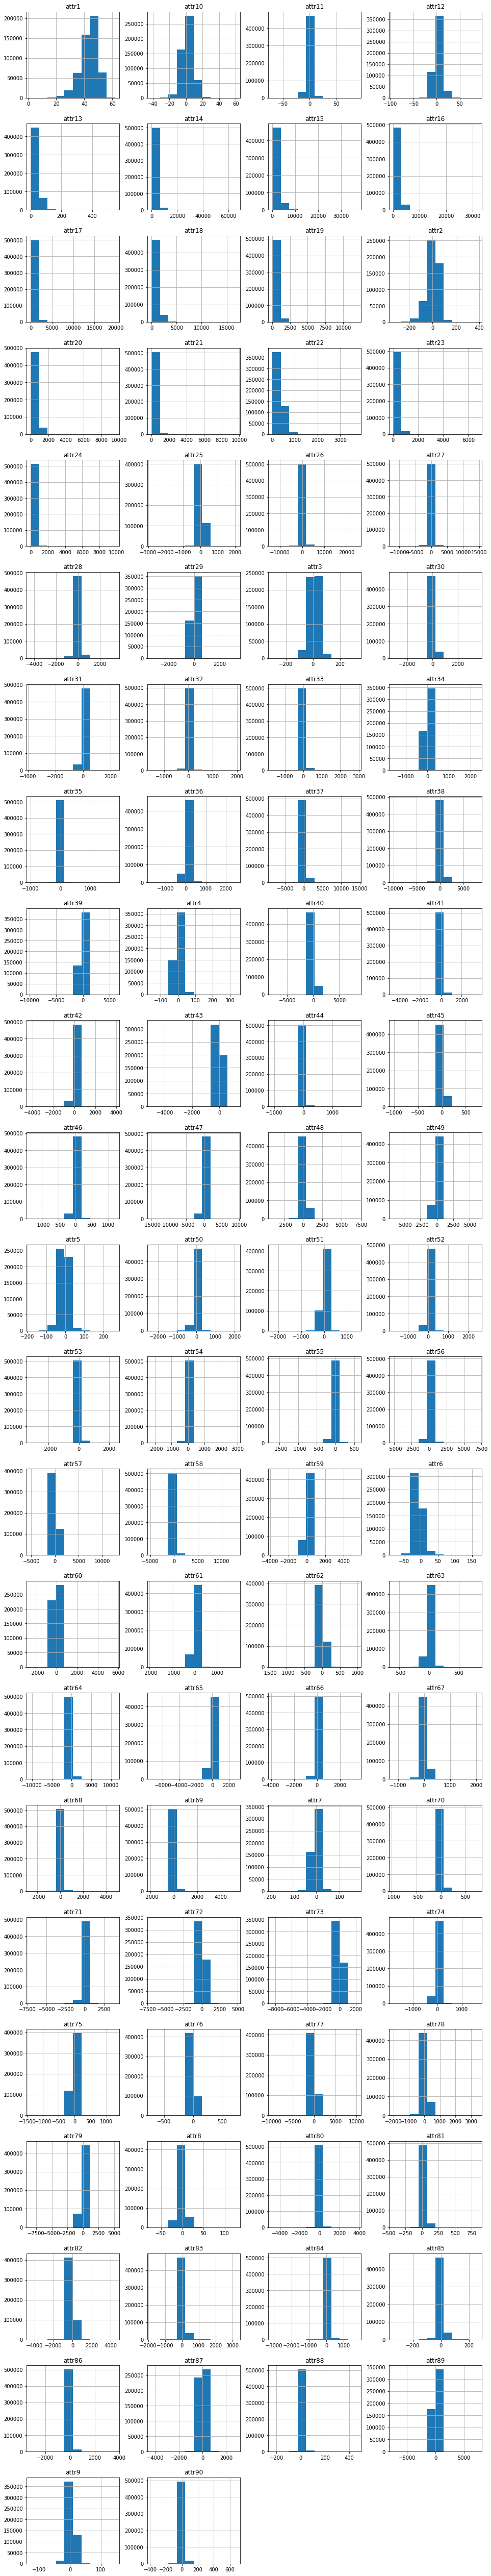

In [26]:
# Histograms for each attribute before pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [27]:
tobe_transformed_cols = X_original.columns.tolist()
# tobe_transformed_cols.remove('some_column_label')
print(tobe_transformed_cols)

['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6', 'attr7', 'attr8', 'attr9', 'attr10', 'attr11', 'attr12', 'attr13', 'attr14', 'attr15', 'attr16', 'attr17', 'attr18', 'attr19', 'attr20', 'attr21', 'attr22', 'attr23', 'attr24', 'attr25', 'attr26', 'attr27', 'attr28', 'attr29', 'attr30', 'attr31', 'attr32', 'attr33', 'attr34', 'attr35', 'attr36', 'attr37', 'attr38', 'attr39', 'attr40', 'attr41', 'attr42', 'attr43', 'attr44', 'attr45', 'attr46', 'attr47', 'attr48', 'attr49', 'attr50', 'attr51', 'attr52', 'attr53', 'attr54', 'attr55', 'attr56', 'attr57', 'attr58', 'attr59', 'attr60', 'attr61', 'attr62', 'attr63', 'attr64', 'attr65', 'attr66', 'attr67', 'attr68', 'attr69', 'attr70', 'attr71', 'attr72', 'attr73', 'attr74', 'attr75', 'attr76', 'attr77', 'attr78', 'attr79', 'attr80', 'attr81', 'attr82', 'attr83', 'attr84', 'attr85', 'attr86', 'attr87', 'attr88', 'attr89', 'attr90']


In [28]:
# Apply feature scaling and transformation
X_original = X_original.astype(float)
scaler = preprocessing.StandardScaler()
X_original[tobe_transformed_cols] = scaler.fit_transform(X_original[tobe_transformed_cols])

X_original.head(-10)

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,attr12,attr13,attr14,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24,attr25,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,attr35,attr36,attr37,attr38,attr39,attr40,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,attr65,attr66,attr67,attr68,attr69,attr70,attr71,attr72,attr73,attr74,attr75,attr76,attr77,attr78,attr79,attr80,attr81,attr82,attr83,attr84,attr85,attr86,attr87,attr88,attr89,attr90
0,1.080575,0.391265,1.826532,0.464657,-0.474730,-0.278204,-1.552371,-1.310845,0.387704,-0.666166,0.793414,-0.584275,-1.056103,-1.045093,-0.805912,-0.747368,-1.055262,-0.858844,-0.873144,-0.903356,-0.666024,-0.836212,-1.008012,-0.734829,-0.423683,-0.504619,0.261180,0.347007,-0.677763,-0.463919,-0.031910,0.144689,0.029940,0.103645,0.171685,-0.676680,-0.198144,-0.443721,0.585406,0.242786,...,-0.339481,-0.429076,0.007435,0.478516,0.050901,-0.310816,0.002206,0.241122,-0.074484,-0.115219,-0.195271,0.155139,-0.272267,0.138797,-0.366056,-0.279650,0.015447,0.371165,-0.035078,0.186311,-0.112104,-0.200706,0.115638,0.302385,0.200496,-0.012610,0.040941,-0.113944,0.251836,0.106465,-0.085335,0.108508,0.142775,-0.237355,0.049233,-0.356182,0.544458,-0.470599,-0.255977,0.042292
1,0.880919,0.332292,1.748539,0.721828,-0.164945,-1.191173,0.765681,0.109626,1.420941,0.414950,0.541252,-0.265139,0.479611,-0.218605,-1.079941,-0.967624,-0.281324,-0.803477,0.449577,-0.488505,-0.355738,-0.317769,-0.786935,0.165365,-0.193934,-0.151685,0.383939,0.744982,-0.681570,-0.974102,0.123618,0.304598,0.309095,-0.535819,1.049858,-0.424444,-0.605081,-0.352097,0.195786,0.870474,...,0.236999,-0.356714,0.831972,-0.544332,-0.559539,0.240032,-0.079926,-0.326565,-0.499388,-0.262564,-0.794017,-0.401863,0.346923,-0.874203,0.196257,0.092991,-0.916031,0.125195,0.137927,-0.797342,0.218263,0.548457,0.251739,0.125429,0.609536,-0.483539,-0.241197,-0.116109,0.409042,-0.692585,-0.314250,0.306236,-0.069483,0.052017,-0.632328,-0.436057,0.556448,0.568744,0.206940,1.158587
2,1.247622,0.592600,1.337173,0.750657,-0.001110,-0.702100,-0.060914,-0.069956,1.166254,-0.074608,0.659382,-0.206489,-1.179183,-0.994540,-0.754449,-0.842576,-1.167197,-0.644427,-0.680438,-0.744836,-1.315763,-0.990010,-0.774182,-0.603851,-0.389326,-0.475469,-0.187041,0.090331,-0.206321,-0.235303,-0.307898,-0.199418,-0.125792,0.578809,0.136693,-0.407285,-0.056498,-0.897922,0.090621,-0.048620,...,0.129665,-0.150860,0.164243,-0.146597,0.026313,-0.034123,0.289001,0.029936,-0.336572,0.194712,-0.099793,0.522931,0.059352,-0.402827,-1.048185,-0.021442,-0.153067,0.460456,-0.279680,-0.026845,0.765419,0.077703,-0.077183,0.873971,-0.154506,0.026094,-0.049322,-0.381945,0.103323,0.315248,-0.396186,0.566683,-0.756534,-0.284019,-0.024220,0.223128,-0.509789,-0.338457,0.105819,-0.090208
3,0.801044,-0.061805,0.783683,0.087218,0.329180,-1.298429,0.510714,-1.073355,-0.016803,-1.262655,1.550430,-0.708817,0.176411,-0.151642,-1.006990,-0.965945,-0.353561,-1.126500,-0.679815,-0.867950,-0.691843,-0.902406,-1.016593,-0.918716,0.292010,-0.147141,0.165074,-0.314855,-0.759269,-0.224530,0.094966,-0.662728,-0.656730,-0.736462,0.478642,-0.342991,-0.313003,-0.466669,0.381073,-0.112344,...,-0.019340,-0.874318,-0.123184,0.126595,0.782474,-0.887411,-0.071854,-0.076723,0.373259,0.056994,-0.417653,0.062135,-0.296027,0.615786,-0.224483,-0.221554,-0.863781,-0.299885,-0.507121,0.054858,-0.452187,0.636184,0.315799,0.839595,-0.239151,-0.878425,0.691674,-0.061946,0.478975,0.470511,0.586237,-0.559427,-0.478689,-0.890161,-0.793906,0.567269,-0.263107,0.408116,0.967862,0.793384
4,1.249775,0.793334,1.657037,0.447460,-0.406775,-0.567138,-0.692498,-0.952197,0.841844,-0.144910,0.401697,-0.042527,0.611278,-0.883220,-0.917862,-1.094474,-1.000481,-0.931815,-0.848601,-0.628978,-0.950142,-0.542465,-1.026901,-0.530277,-0.308223,-0.339436,0.461216,-0.226700,-0.494780,-0.381546,-0.174435,-0.388365,0.150394,-0.301324,0.862572,-0.569401,-

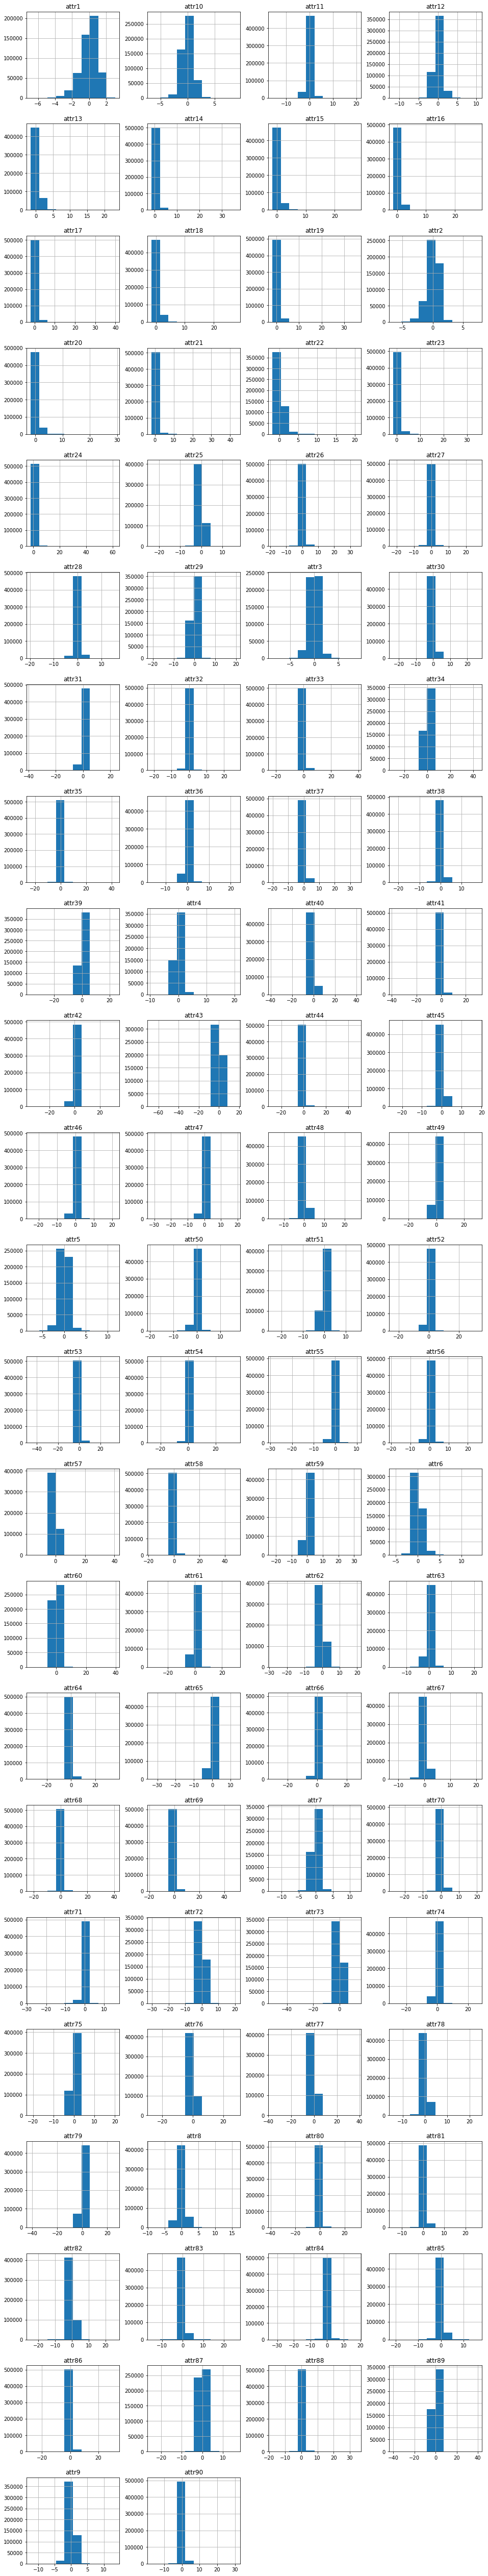

In [29]:
# Histograms for each attribute after pre-processing
X_original.hist(layout=(dispRow,dispCol))
plt.show()

## 1.d) Splitting Data into Training and Test Sets

In [0]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [31]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
# if (splitDataset):
#     X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
# else:
#     X_train, y_train = X_encoded, y_encoded
#     X_test, y_test = X_encoded, y_encoded

split_point = 463715
X_train = X_encoded[:split_point]
y_train = y_encoded[:split_point]
X_test = X_encoded[split_point:]
y_test = y_encoded[split_point:]
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (463715, 90) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (463715,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (51630, 90) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (51630,) y_test.type: <class 'numpy.ndarray'>


In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of modeling

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of modeling

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Explore Different Three-Layer Models with Dropout and Batch Normalization

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different One-Layer Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Define MLP model #5A_1
def create_model_5A_1():
    default_model = Sequential()
    default_model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(4, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5A_1 = create_model_5A_1()
extra_epochs = 0
baseline_hist = baseline_model_5A_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5A_1 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 63s 136us/sample - loss: 2590618.2030 - val_loss: 754300.7317
Epoch 2/50
463715/463715 [==============================] - 61s 132us/sample - loss: 118364.0890 - val_loss: 80.4534
Epoch 3/50
463715/463715 [==============================] - 62s 133us/sample - loss: 80.3476 - val_loss: 79.2935
Epoch 4/50
463715/463715 [==============================] - 61s 132us/sample - loss: 79.8021 - val_loss: 79.1551
Epoch 5/50
463715/463715 [==============================] - 62s 133us/sample - loss: 79.5943 - val_loss: 78.8694
Epoch 6/50
463715/463715 [==============================] - 62s 134us/sample - loss: 79.5543 - val_loss: 78.9681
Epoch 7/50
463715/463715 [==============================] - 62s 133us/sample - loss: 79.3576 - val_loss: 78.7317
Epoch 8/50
463715/463715 [==============================] - 62s 135us/sample - loss: 79.2386 - val_loss: 78.6825
Epoch 9/50
463715/463715 [======

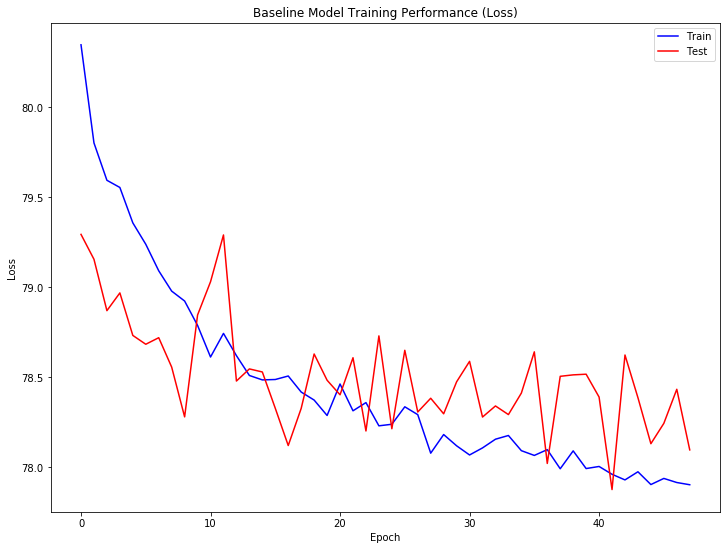

In [41]:
# Summarize model 5A_1 training hisotry
begin_epoch = 2
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [42]:
# Define MLP model #5A_2
def create_model_5A_2():
    default_model = Sequential()
    default_model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(4, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5A_2 = create_model_5A_2()
extra_epochs = 0
baseline_hist = baseline_model_5A_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5A_2 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 62s 133us/sample - loss: 2355918.3225 - val_loss: 541522.7090
Epoch 2/50
463715/463715 [==============================] - 62s 133us/sample - loss: 72130.8429 - val_loss: 79.8498
Epoch 3/50
463715/463715 [==============================] - 61s 131us/sample - loss: 81.5087 - val_loss: 79.0513
Epoch 4/50
463715/463715 [==============================] - 61s 133us/sample - loss: 80.9662 - val_loss: 79.0370
Epoch 5/50
463715/463715 [==============================] - 61s 132us/sample - loss: 80.9037 - val_loss: 78.8216
Epoch 6/50
463715/463715 [==============================] - 61s 132us/sample - loss: 80.7926 - val_loss: 78.8980
Epoch 7/50
463715/463715 [==============================] - 61s 132us/sample - loss: 80.6675 - val_loss: 78.7588
Epoch 8/50
463715/463715 [==============================] - 61s 132us/sample - loss: 80.6989 - val_loss: 79.0081
Epoch 9/50
463715/463715 [=======

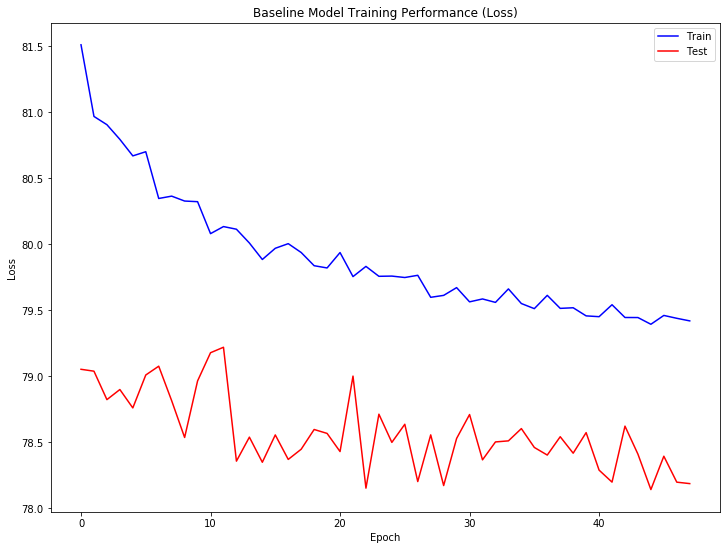

In [43]:
# Summarize model 5A_2 training hisotry
begin_epoch = 2
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [44]:
# Define MLP model #5A_3
def create_model_5A_3():
    default_model = Sequential()
    default_model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(4, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5A_3 = create_model_5A_3()
extra_epochs = 0
baseline_hist = baseline_model_5A_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5A_3 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 63s 136us/sample - loss: 2355802.2653 - val_loss: 541428.1489
Epoch 2/50
463715/463715 [==============================] - 62s 134us/sample - loss: 72110.8153 - val_loss: 80.2355
Epoch 3/50
463715/463715 [==============================] - 62s 134us/sample - loss: 82.1813 - val_loss: 79.4137
Epoch 4/50
463715/463715 [==============================] - 62s 133us/sample - loss: 81.6527 - val_loss: 79.4503
Epoch 5/50
463715/463715 [==============================] - 62s 134us/sample - loss: 81.5357 - val_loss: 78.8018
Epoch 6/50
463715/463715 [==============================] - 62s 133us/sample - loss: 81.4015 - val_loss: 79.1900
Epoch 7/50
463715/463715 [==============================] - 62s 134us/sample - loss: 81.3497 - val_loss: 78.9488
Epoch 8/50
463715/463715 [==============================] - 61s 132us/sample - loss: 81.1807 - val_loss: 79.2380
Epoch 9/50
463715/463715 [=======

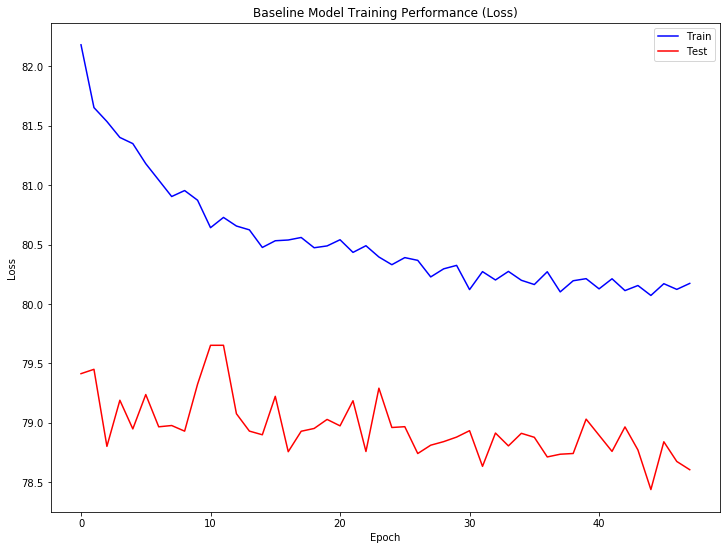

In [45]:
# Summarize model 5A_3 training hisotry
begin_epoch = 2
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [46]:
# Define MLP model #5B_1
def create_model_5B_1():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5B_1 = create_model_5B_1()
extra_epochs = 0
baseline_hist = baseline_model_5B_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5B_1 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 61s 131us/sample - loss: 1583127.3743 - val_loss: 1643.1962
Epoch 2/50
463715/463715 [==============================] - 61s 131us/sample - loss: 112.5393 - val_loss: 79.2640
Epoch 3/50
463715/463715 [==============================] - 60s 130us/sample - loss: 79.5101 - val_loss: 78.3651
Epoch 4/50
463715/463715 [==============================] - 60s 129us/sample - loss: 78.8297 - val_loss: 78.1708
Epoch 5/50
463715/463715 [==============================] - 60s 129us/sample - loss: 78.4326 - val_loss: 78.1475
Epoch 6/50
463715/463715 [==============================] - 60s 130us/sample - loss: 78.2497 - val_loss: 78.4549
Epoch 7/50
463715/463715 [==============================] - 61s 130us/sample - loss: 77.9974 - val_loss: 77.9785
Epoch 8/50
463715/463715 [==============================] - 61s 132us/sample - loss: 77.7593 - val_loss: 77.7076
Epoch 9/50
463715/463715 [===========

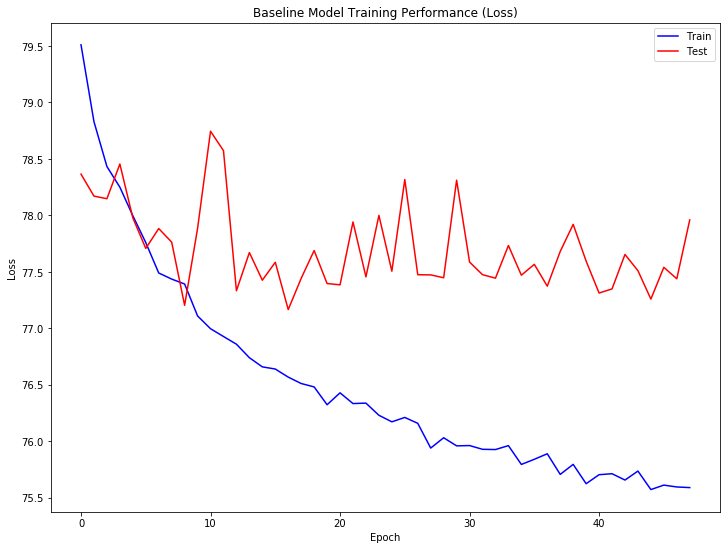

In [47]:
# Summarize model 5B_1 training hisotry
begin_epoch = 2
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [48]:
# Define MLP model #5B_2
def create_model_5B_2():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5B_2 = create_model_5B_2()
extra_epochs = 0
baseline_hist = baseline_model_5B_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5B_2 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 62s 133us/sample - loss: 1583122.3277 - val_loss: 1646.2984
Epoch 2/50
463715/463715 [==============================] - 61s 132us/sample - loss: 113.6327 - val_loss: 79.2859
Epoch 3/50
463715/463715 [==============================] - 61s 132us/sample - loss: 80.5075 - val_loss: 78.6926
Epoch 4/50
463715/463715 [==============================] - 62s 133us/sample - loss: 79.7839 - val_loss: 78.5045
Epoch 5/50
463715/463715 [==============================] - 62s 133us/sample - loss: 79.5143 - val_loss: 78.1170
Epoch 6/50
463715/463715 [==============================] - 61s 131us/sample - loss: 79.3553 - val_loss: 78.3067
Epoch 7/50
463715/463715 [==============================] - 61s 133us/sample - loss: 79.1440 - val_loss: 77.8501
Epoch 8/50
463715/463715 [==============================] - 61s 132us/sample - loss: 79.0002 - val_loss: 78.3216
Epoch 9/50
463715/463715 [===========

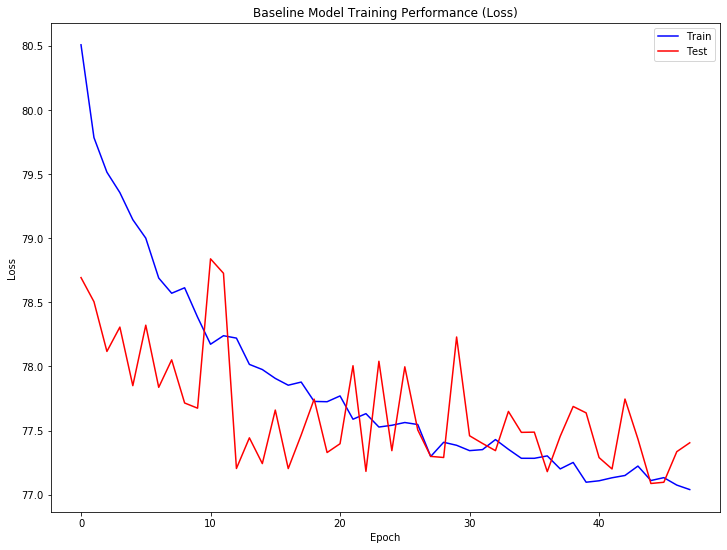

In [49]:
# Summarize model 5B_2 training hisotry
begin_epoch = 2
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [50]:
# Define MLP model #5B_3
def create_model_5B_3():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(8, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5B_3 = create_model_5B_3()
extra_epochs = 0
baseline_hist = baseline_model_5B_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5B_3 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 63s 136us/sample - loss: 1583202.7630 - val_loss: 1632.5024
Epoch 2/50
463715/463715 [==============================] - 62s 133us/sample - loss: 113.7146 - val_loss: 78.9011
Epoch 3/50
463715/463715 [==============================] - 62s 134us/sample - loss: 80.8688 - val_loss: 78.4732
Epoch 4/50
463715/463715 [==============================] - 62s 133us/sample - loss: 80.1917 - val_loss: 78.6770
Epoch 5/50
463715/463715 [==============================] - 61s 133us/sample - loss: 79.8394 - val_loss: 78.0458
Epoch 6/50
463715/463715 [==============================] - 62s 133us/sample - loss: 79.7329 - val_loss: 78.1958
Epoch 7/50
463715/463715 [==============================] - 62s 133us/sample - loss: 79.5978 - val_loss: 77.8345
Epoch 8/50
463715/463715 [==============================] - 61s 133us/sample - loss: 79.3751 - val_loss: 77.9785
Epoch 9/50
463715/463715 [===========

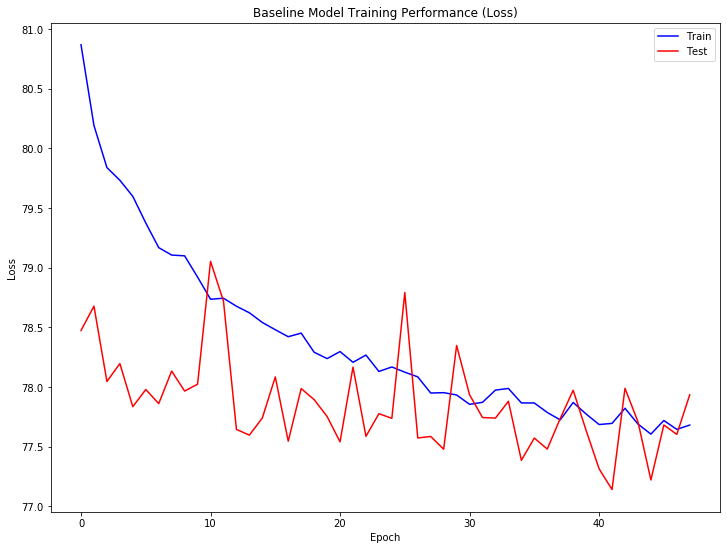

In [51]:
# Summarize model 5B_3 training hisotry
begin_epoch = 2
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [52]:
# Define MLP model #5C_1
def create_model_5C_1():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5C_1 = create_model_5C_1()
extra_epochs = 0
baseline_hist = baseline_model_5C_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5C_1 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 61s 131us/sample - loss: 1003628.0310 - val_loss: 79.8729
Epoch 2/50
463715/463715 [==============================] - 60s 128us/sample - loss: 79.8890 - val_loss: 78.8339
Epoch 3/50
463715/463715 [==============================] - 59s 128us/sample - loss: 78.6873 - val_loss: 78.0363
Epoch 4/50
463715/463715 [==============================] - 60s 128us/sample - loss: 77.8259 - val_loss: 78.0062
Epoch 5/50
463715/463715 [==============================] - 60s 129us/sample - loss: 77.3431 - val_loss: 77.5827
Epoch 6/50
463715/463715 [==============================] - 60s 129us/sample - loss: 77.0242 - val_loss: 77.8791
Epoch 7/50
463715/463715 [==============================] - 60s 129us/sample - loss: 76.6731 - val_loss: 77.7099
Epoch 8/50
463715/463715 [==============================] - 60s 129us/sample - loss: 76.3629 - val_loss: 77.5786
Epoch 9/50
463715/463715 [==============

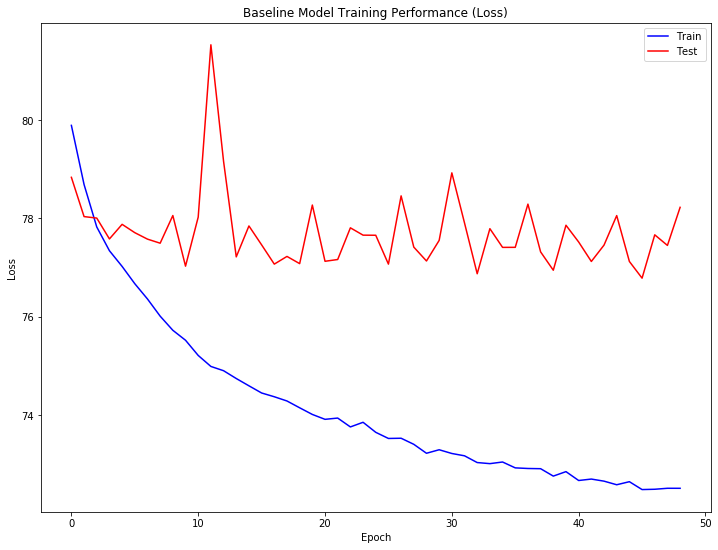

In [53]:
# Summarize model 5C_1 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [54]:
# Define MLP model #5C_2
def create_model_5C_2():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5C_2 = create_model_5C_2()
extra_epochs = 0
baseline_hist = baseline_model_5C_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5C_2 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 62s 134us/sample - loss: 1003616.8359 - val_loss: 80.5759
Epoch 2/50
463715/463715 [==============================] - 61s 132us/sample - loss: 80.5269 - val_loss: 78.8405
Epoch 3/50
463715/463715 [==============================] - 62s 134us/sample - loss: 79.5052 - val_loss: 77.9612
Epoch 4/50
463715/463715 [==============================] - 62s 134us/sample - loss: 78.6844 - val_loss: 78.7203
Epoch 5/50
463715/463715 [==============================] - 62s 133us/sample - loss: 78.3025 - val_loss: 77.7214
Epoch 6/50
463715/463715 [==============================] - 62s 134us/sample - loss: 78.1398 - val_loss: 77.7652
Epoch 7/50
463715/463715 [==============================] - 61s 132us/sample - loss: 77.7723 - val_loss: 77.1529
Epoch 8/50
463715/463715 [==============================] - 62s 133us/sample - loss: 77.4828 - val_loss: 77.1692
Epoch 9/50
463715/463715 [==============

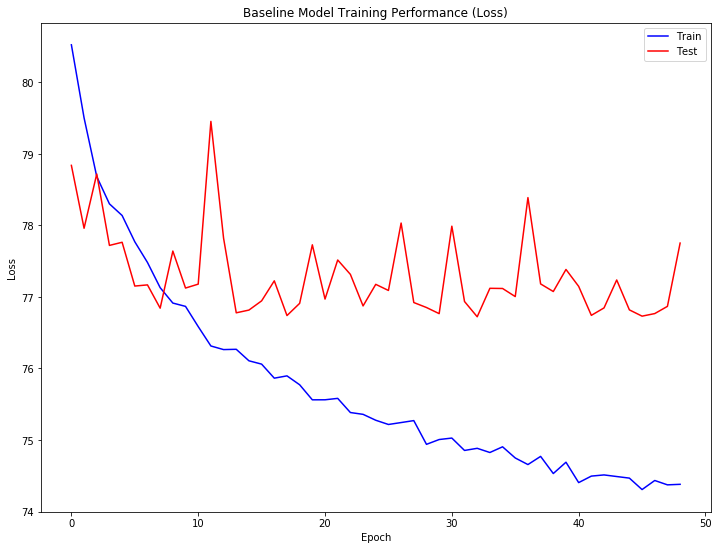

In [55]:
# Summarize model 5C_2 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [56]:
# Define MLP model #5C_3
def create_model_5C_3():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(16, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5C_3 = create_model_5C_3()
extra_epochs = 0
baseline_hist = baseline_model_5C_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5C_3 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 61s 131us/sample - loss: 1003681.9297 - val_loss: 79.6542
Epoch 2/50
463715/463715 [==============================] - 61s 131us/sample - loss: 81.2446 - val_loss: 78.8232
Epoch 3/50
463715/463715 [==============================] - 60s 130us/sample - loss: 80.0545 - val_loss: 78.0243
Epoch 4/50
463715/463715 [==============================] - 61s 131us/sample - loss: 79.3620 - val_loss: 78.2129
Epoch 5/50
463715/463715 [==============================] - 61s 132us/sample - loss: 78.9157 - val_loss: 77.8740
Epoch 6/50
463715/463715 [==============================] - 60s 130us/sample - loss: 78.7108 - val_loss: 78.1406
Epoch 7/50
463715/463715 [==============================] - 61s 131us/sample - loss: 78.3392 - val_loss: 77.5308
Epoch 8/50
463715/463715 [==============================] - 61s 131us/sample - loss: 78.0359 - val_loss: 77.6751
Epoch 9/50
463715/463715 [==============

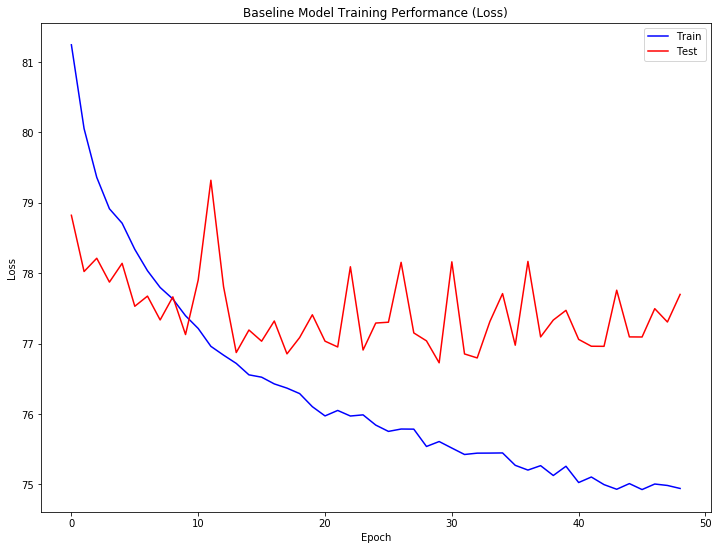

In [57]:
# Summarize model 5C_3 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [58]:
# Define MLP model #5D_1
def create_model_5D_1():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5D_1 = create_model_5D_1()
extra_epochs = 0
baseline_hist = baseline_model_5D_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5D_1 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 59s 128us/sample - loss: 617121.9482 - val_loss: 80.2371
Epoch 2/50
463715/463715 [==============================] - 59s 127us/sample - loss: 79.4570 - val_loss: 78.7297
Epoch 3/50
463715/463715 [==============================] - 59s 127us/sample - loss: 78.0937 - val_loss: 78.1767
Epoch 4/50
463715/463715 [==============================] - 59s 127us/sample - loss: 77.0298 - val_loss: 78.2839
Epoch 5/50
463715/463715 [==============================] - 59s 127us/sample - loss: 76.3279 - val_loss: 76.9968
Epoch 6/50
463715/463715 [==============================] - 58s 126us/sample - loss: 75.8676 - val_loss: 77.1443
Epoch 7/50
463715/463715 [==============================] - 59s 128us/sample - loss: 75.3688 - val_loss: 77.5834
Epoch 8/50
463715/463715 [==============================] - 59s 128us/sample - loss: 74.9054 - val_loss: 76.9709
Epoch 9/50
463715/463715 [===============

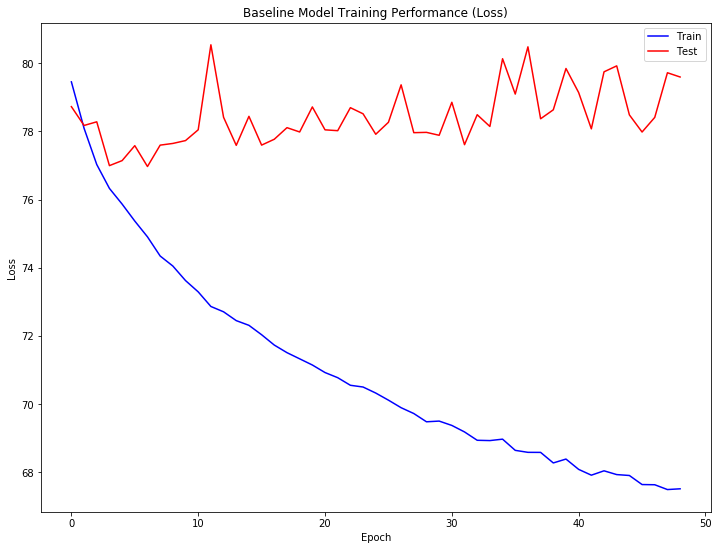

In [59]:
# Summarize model 5D_1 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [60]:
# Define MLP model #5D_2
def create_model_5D_2():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5D_2 = create_model_5D_2()
extra_epochs = 0
baseline_hist = baseline_model_5D_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5D_2 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 61s 131us/sample - loss: 617145.9195 - val_loss: 80.5818
Epoch 2/50
463715/463715 [==============================] - 61s 131us/sample - loss: 80.3033 - val_loss: 78.8294
Epoch 3/50
463715/463715 [==============================] - 61s 131us/sample - loss: 79.0132 - val_loss: 78.3396
Epoch 4/50
463715/463715 [==============================] - 60s 130us/sample - loss: 77.9237 - val_loss: 78.0621
Epoch 5/50
463715/463715 [==============================] - 61s 131us/sample - loss: 77.3979 - val_loss: 77.7948
Epoch 6/50
463715/463715 [==============================] - 60s 129us/sample - loss: 77.0581 - val_loss: 78.0665
Epoch 7/50
463715/463715 [==============================] - 60s 129us/sample - loss: 76.5883 - val_loss: 77.5802
Epoch 8/50
463715/463715 [==============================] - 60s 130us/sample - loss: 76.1522 - val_loss: 77.2398
Epoch 9/50
463715/463715 [===============

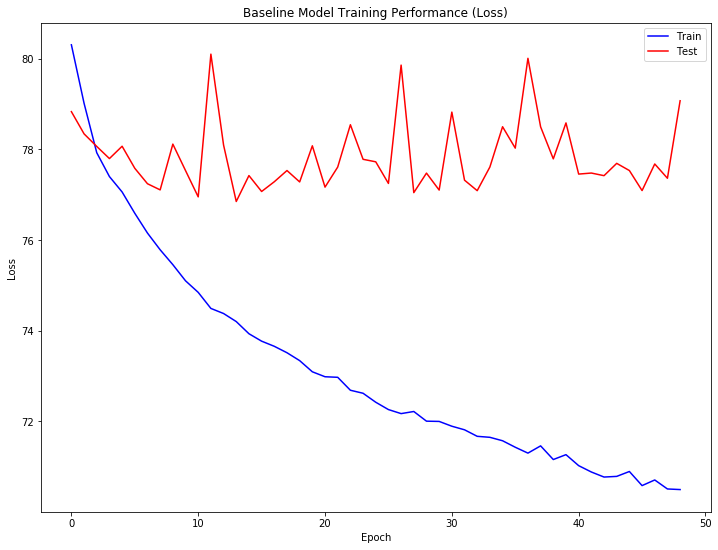

In [61]:
# Summarize model 5D_2 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [62]:
# Define MLP model #5D_3
def create_model_5D_3():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(32, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5D_3 = create_model_5D_3()
extra_epochs = 0
baseline_hist = baseline_model_5D_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5D_3 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 64s 138us/sample - loss: 617146.3182 - val_loss: 79.9550
Epoch 2/50
463715/463715 [==============================] - 63s 136us/sample - loss: 80.7536 - val_loss: 78.5579
Epoch 3/50
463715/463715 [==============================] - 63s 135us/sample - loss: 79.4820 - val_loss: 77.8499
Epoch 4/50
463715/463715 [==============================] - 62s 135us/sample - loss: 78.4755 - val_loss: 78.4286
Epoch 5/50
463715/463715 [==============================] - 63s 135us/sample - loss: 77.7951 - val_loss: 77.1798
Epoch 6/50
463715/463715 [==============================] - 63s 135us/sample - loss: 77.4654 - val_loss: 77.6682
Epoch 7/50
463715/463715 [==============================] - 62s 134us/sample - loss: 76.9785 - val_loss: 77.4160
Epoch 8/50
463715/463715 [==============================] - 62s 134us/sample - loss: 76.6878 - val_loss: 76.9697
Epoch 9/50
463715/463715 [===============

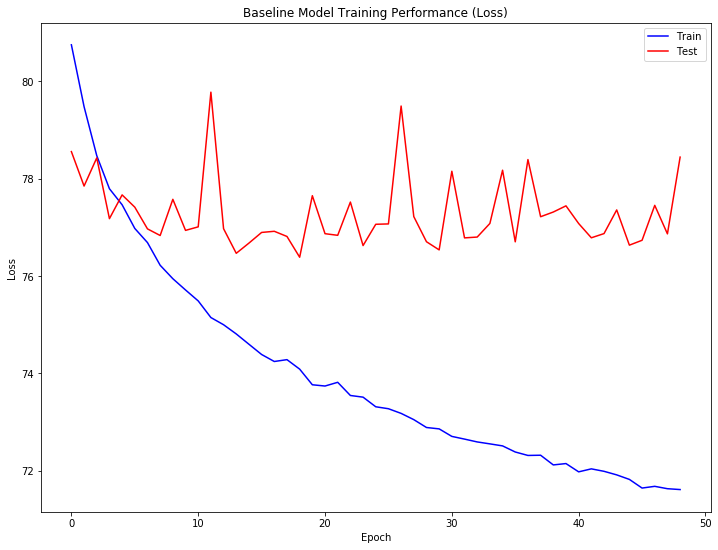

In [63]:
# Summarize model 5D_3 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
# Define MLP model #5E_1
def create_model_5E_1():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5E_1 = create_model_5E_1()
extra_epochs = 0
baseline_hist = baseline_model_5E_1.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5E_1 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 60s 129us/sample - loss: 368293.7312 - val_loss: 79.8541
Epoch 2/50
463715/463715 [==============================] - 60s 129us/sample - loss: 79.4887 - val_loss: 79.0612
Epoch 3/50
463715/463715 [==============================] - 59s 128us/sample - loss: 77.7904 - val_loss: 77.7497
Epoch 4/50
463715/463715 [==============================] - 59s 128us/sample - loss: 76.5425 - val_loss: 78.2889
Epoch 5/50
463715/463715 [==============================] - 59s 128us/sample - loss: 75.7542 - val_loss: 76.7844
Epoch 6/50
463715/463715 [==============================] - 59s 128us/sample - loss: 75.0768 - val_loss: 76.7755
Epoch 7/50
463715/463715 [==============================] - 60s 128us/sample - loss: 74.3339 - val_loss: 78.5619
Epoch 8/50
463715/463715 [==============================] - 60s 129us/sample - loss: 73.5718 - val_loss: 78.1882
Epoch 9/50
463715/463715 [===============

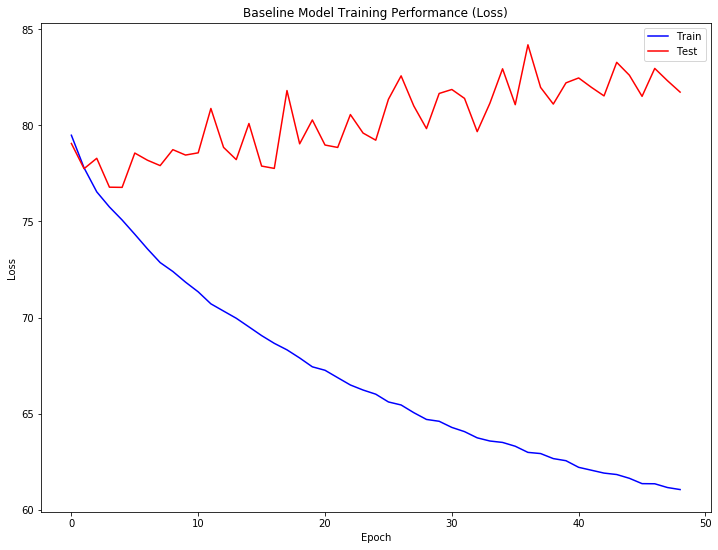

In [0]:
# Summarize model 5E_1 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
# Define MLP model #5E_2
def create_model_5E_2():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5E_2 = create_model_5E_2()
extra_epochs = 0
baseline_hist = baseline_model_5E_2.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5E_2 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 60s 129us/sample - loss: 368266.6007 - val_loss: 81.7871
Epoch 2/50
463715/463715 [==============================] - 59s 128us/sample - loss: 80.3432 - val_loss: 79.0308
Epoch 3/50
463715/463715 [==============================] - 59s 127us/sample - loss: 78.7334 - val_loss: 78.5795
Epoch 4/50
463715/463715 [==============================] - 59s 128us/sample - loss: 77.6353 - val_loss: 78.4225
Epoch 5/50
463715/463715 [==============================] - 59s 127us/sample - loss: 76.8807 - val_loss: 77.6191
Epoch 6/50
463715/463715 [==============================] - 59s 127us/sample - loss: 76.3658 - val_loss: 77.0019
Epoch 7/50
463715/463715 [==============================] - 59s 128us/sample - loss: 75.8106 - val_loss: 77.3209
Epoch 8/50
463715/463715 [==============================] - 59s 127us/sample - loss: 75.2074 - val_loss: 77.3997
Epoch 9/50
463715/463715 [===============

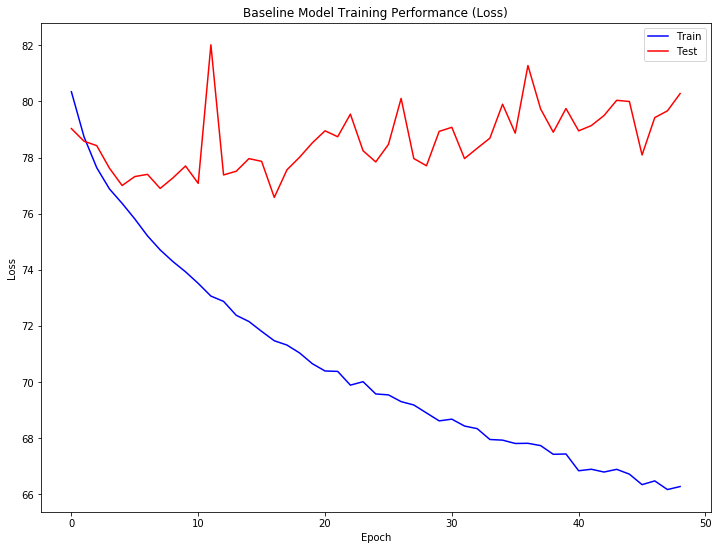

In [0]:
# Summarize model 5E_2 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
# Define MLP model #5E_3
def create_model_5E_3():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dropout(0.1))
    default_model.add(Dense(64, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(BatchNormalization())
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

# Initialize and fit the model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model_5E_3 = create_model_5E_3()
extra_epochs = 0
baseline_hist = baseline_model_5E_3.fit(X_train, y_train, epochs=(default_epoch + extra_epochs), batch_size=default_batch, 
                                      validation_data=(X_test, y_test), verbose=1)
print('The minimum RMSE for the training dataset:', math.sqrt(min(baseline_hist.history['loss'])))
print('The RMSE at the last epoch for the training dataset:', math.sqrt(baseline_hist.history['loss'][-1]))
print('The minimum RMSE for the test dataset:', math.sqrt(min(baseline_hist.history['val_loss'])))
print('The RMSE at the last epoch for the test dataset:', math.sqrt(baseline_hist.history['val_loss'][-1]))
print('Total time for model fitting:', (datetime.now() - startTimeModule), '\n')
if (notifyStatus): email_notify("Model 5E_3 processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Train on 463715 samples, validate on 51630 samples
Epoch 1/50
463715/463715 [==============================] - 63s 136us/sample - loss: 368279.8840 - val_loss: 79.4315
Epoch 2/50
463715/463715 [==============================] - 61s 131us/sample - loss: 80.1942 - val_loss: 78.0805
Epoch 3/50
463715/463715 [==============================] - 61s 131us/sample - loss: 78.6749 - val_loss: 77.6667
Epoch 4/50
463715/463715 [==============================] - 61s 131us/sample - loss: 77.4870 - val_loss: 77.5368
Epoch 5/50
463715/463715 [==============================] - 60s 130us/sample - loss: 76.7755 - val_loss: 77.0283
Epoch 6/50
463715/463715 [==============================] - 61s 132us/sample - loss: 76.3524 - val_loss: 76.6184
Epoch 7/50
463715/463715 [==============================] - 61s 131us/sample - loss: 75.7629 - val_loss: 77.2000
Epoch 8/50
463715/463715 [==============================] - 61s 131us/sample - loss: 75.2446 - val_loss: 77.6107
Epoch 9/50
463715/463715 [===============

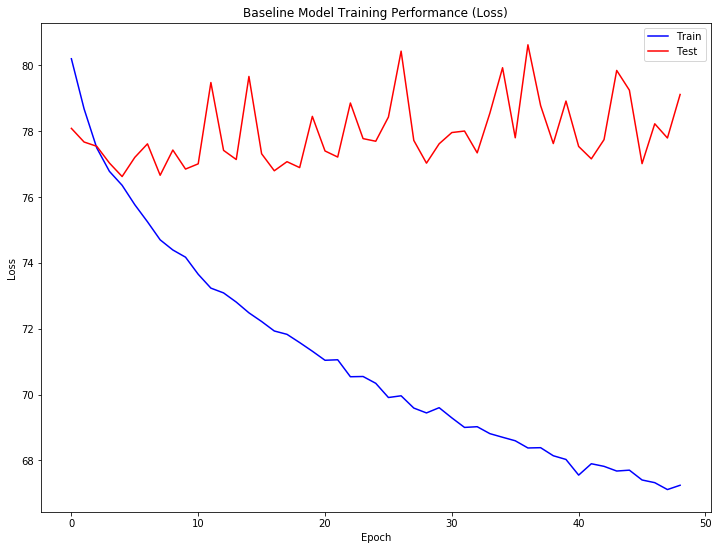

In [0]:
# Summarize model 5E_3 training hisotry
begin_epoch = 1
fig, axs = plt.subplots(1, 1, figsize=(12,9))
plt.subplot(111)
plt.plot(baseline_hist.history['loss'][begin_epoch:], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'][begin_epoch:], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 4 Explore Different One-Layer Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Display a summary of the final model
# final_model = baseline_model_5E
# print(final_model.summary())

In [0]:
# Display the configuration of the final model
# print(final_model.get_config())

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [69]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 11:22:48.665805
